## Install dependencies and initialize

In [10]:
!pip install torchaudio
# !pip install tensorboard
!pip install audiomentations

  Using cached audiomentations-0.16.0-py3-none-any.whl (24 kB)
  Using cached scipy-1.5.4-cp38-cp38-manylinux1_x86_64.whl (25.8 MB)
  Using cached librosa-0.8.0-py3-none-any.whl
  Using cached resampy-0.2.2-py3-none-any.whl
  Using cached SoundFile-0.10.3.post1-py2.py3-none-any.whl (21 kB)
  Using cached pooch-1.4.0-py3-none-any.whl (51 kB)
  Using cached audioread-2.1.9-py3-none-any.whl
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2


In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
# current torch version is 1.7.0+cu101
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
import time
from tqdm.notebook import tqdm
import copy

In [3]:
# check if cuda GPU is available, make sure you're using GPU runtime on Google Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # you should output "cuda"

cuda


## Load dataset

We create a loader for the full dataset to observe the data

In [20]:
# !gdown --id 1im5shxcavdoTRNT66mhVdtA_E0ZR8QLl
# !unzip s1_train_release.zip

In [21]:
class CustomSpeechDataset(torch.utils.data.Dataset):
  def __init__(self, path, typ='train', transforms=None):

    assert typ == 'train' or typ == 'test', 'typ must be either "train" or "test"'

    self.typ = typ
    self.transforms = transforms
    self.targets = []

    if self.typ == 'train':
      self.class_names = sorted(os.listdir(path))
      num_classes = len(self.class_names)

      for class_idx, class_name in enumerate(self.class_names):
        class_dirx = os.path.join(path, class_name)
        wav_list = os.listdir(class_dirx)

        for wav_file in wav_list:
          self.targets.append({
              'filename': wav_file,
              'path': os.path.join(class_dirx, wav_file),
              'class': class_name
          })

    if self.typ == 'test':
      wav_list = os.listdir(path)
      for wav_file in wav_list:
        self.targets.append({
            'filename': wav_file,
            'path': os.path.join(path, wav_file)
        })
  
  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx.tolist()

    # signal, sr = torchaudio.load(self.targets[idx]['path'], normalization=True)
    signal, sr = torchaudio.load(self.targets[idx]['path'])
    filename = self.targets[idx]['filename']

    if self.transforms:
      for transform in self.transforms:
        signal = transform(signal)

    if self.typ == 'train':
      clx_name = self.targets[idx]['class']
      return filename, signal, sr, clx_name
    
    elif self.typ == 'test':
      return filename, signal, sr

In [22]:
full_dataset = CustomSpeechDataset(path='s1_train_release', typ='train')
labels = full_dataset.class_names
sample_rates = []
for i in range(len(full_dataset)):
  sample_rates.append(full_dataset[i][2])

audio_lens = []
for i in range(len(full_dataset)):
  audio_lens.append(full_dataset[i][1].size(1))

if (max(audio_lens) != min(audio_lens)):
  raise AssertionError("The audio clips do not have a constant number of samples")
else:
  audio_len = max(audio_lens)
  print("Sample Length:", audio_len)


if (max(sample_rates) != min(sample_rates)):
  raise AssertionError("The sample rates of the audio clips are not all the same")
else:
  sample_rate = max(sample_rates)
  print("Sample Rate:", sample_rate)

labels_to_indices = {}
for idx, l in enumerate(labels):
  labels_to_indices[l] = idx

print("Dataset size: ",len(full_dataset))
print("Classes: ",labels)
print(labels_to_indices)

Sample Length: 16000
Sample Rate: 16000
Dataset size:  3250
Classes:  ['bird', 'eight', 'falcon', 'five', 'four', 'nine', 'one', 'seven', 'six', 'snake', 'three', 'two', 'zero']
{'bird': 0, 'eight': 1, 'falcon': 2, 'five': 3, 'four': 4, 'nine': 5, 'one': 6, 'seven': 7, 'six': 8, 'snake': 9, 'three': 10, 'two': 11, 'zero': 12}


## Data processing

We create two custom datasets which perform conversion of the audio to a melspectrogram. 
One of the custom datasets will have augmentation performed to the audio (gaussian noise, gain)


## Conversion to spectrogram

We define the transforms needed to convert the audio to a spectrogram. Audio augmentation happens here

In [23]:
from audiomentations import Compose, AddGaussianNoise, AddGaussianSNR, Gain, PitchShift, TimeStretch
from torchaudio.transforms import MelSpectrogram

class PadAudio(torch.nn.Module):
  def __init__(self, req_length = 16000):
    super().__init__()
    self.req_length = req_length

  def forward(self, waveform):
    while waveform.size(1) < self.req_length:
      waveform = torch.cat((waveform, waveform[:, :self.req_length - waveform.size(1)]), axis=1)
    return waveform

class AudioAugmentations(torch.nn.Module):
  def __init__(self,sample_rate):
    super().__init__()
    self.sample_rate = sample_rate
    self.audioAugmentationsList = [
        AddGaussianNoise(p=0.5),
        AddGaussianSNR(p=0.2),
        PitchShift(min_semitones=-2, max_semitones=2),
#         TimeStretch(p=1),
        Gain(min_gain_in_db=-15,max_gain_in_db=15,p=0.3),
        ]
    self.audioAugmentationsList  
  def forward(self, waveform):
    waveform = waveform.numpy()
    for transform in self.audioAugmentationsList:
      waveform = transform(waveform,self.sample_rate)
    waveform = torch.from_numpy(waveform)
    return waveform

class LogMelTransform(torch.nn.Module):

    def __init__(self, log_offset = 1e-6):
        super().__init__()
        self.log_offset = log_offset

    def forward(self, melspectrogram):
        return torch.log(melspectrogram + self.log_offset)

base_processing = [PadAudio(req_length=audio_len),
                   MelSpectrogram(sample_rate=sample_rate,n_mels=224),
                   LogMelTransform()]
base_processing_augmented = base_processing.copy()
base_processing_augmented.insert(1,AudioAugmentations(sample_rate=sample_rate))

In [24]:
print("Base processing:",base_processing)
print("Augmented processing:",base_processing_augmented)

Base processing: [PadAudio(), MelSpectrogram(
  (spectrogram): Spectrogram()
  (mel_scale): MelScale()
), LogMelTransform()]
Augmented processing: [PadAudio(), AudioAugmentations(), MelSpectrogram(
  (spectrogram): Spectrogram()
  (mel_scale): MelScale()
), LogMelTransform()]


In [25]:
spectrogram_dataset = CustomSpeechDataset(
    path='s1_train_release',
    typ='train',
    transforms=base_processing)
spectrogram_augmented_dataset = CustomSpeechDataset(
    path="s1_train_release",
    typ="train",
    transforms=base_processing_augmented
)

## Processing of spectrogram

We perform frequency masking and time masking to the spectrograms. 

We then convert it to an RGB image of size 224,224 by duplicating the single channel across R,G, and B. This is necessary to get it to work with the pretrained imagenet models.

In [12]:
from torchaudio.transforms import TimeMasking, FrequencyMasking

from torchvision import transforms as T

class FakeRGB(torch.nn.Module):

    def __init__(self):
        super().__init__()


    def forward(self, x):
        x.unsqueeze(0)
        x = x.repeat(3, 1, 1)
        return x


spectrogram_processing = [FakeRGB(),
                          T.Resize((224,224)),
                          T.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])]

spectrogram_augmented = [TimeMasking(time_mask_param=5),
                          FrequencyMasking(freq_mask_param=3)] + spectrogram_processing
                          

In [13]:
print("Base spectrogram processing:",spectrogram_processing)
print("Augmented spectrogram processing:",spectrogram_augmented)

Base spectrogram processing: [FakeRGB(), Resize(size=(224, 224), interpolation=bilinear), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
Augmented spectrogram processing: [TimeMasking(), FrequencyMasking(), FakeRGB(), Resize(size=(224, 224), interpolation=bilinear), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]


## Check our augmented data

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


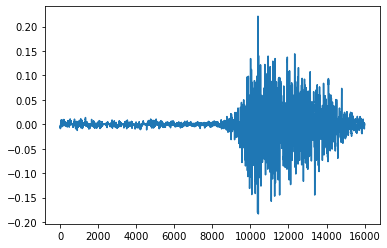

In [12]:
filename, waveform, sample_rate, label_id = full_dataset[0]
for transform in (base_processing_augmented[:-2]):
  waveform = transform(waveform)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))


plt.plot(waveform.t().numpy());
ipd.Audio(waveform.numpy(), rate=sample_rate)

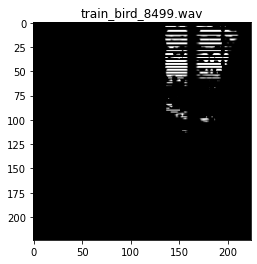

In [40]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# filename, waveform, sample_rate, label_id = spectrogram_augmented_dataset[0]
# print(waveform.shape)
filename, waveform, sample_rate, label_id = full_dataset[0]
for transform in (base_processing_augmented):
  waveform = transform(waveform)
for transform in spectrogram_augmented:
  waveform= transform(waveform)


# Make a grid from batch
out = torchvision.utils.make_grid(waveform)

imshow(out, title=filename)

## Set up our training loop

We first set up a function to generate collate functions for our future dataloaders. Note that the processing of our raw spectrograms and tokenization is done here in the collating function.

In [14]:
BATCH_SIZE = 4
NUM_WORKERS = 4
PIN_MEMORY = True if device == 'cuda' else False

In [15]:
def create_collate_fn(transformations=None):
  def collate_fn(batch):

      # A data tuple has the form:
      # filename, waveform, sample_rate, label

      tensors, targets, filenames = [], [], []

      # Gather in lists, and encode labels as indices
      for filename, waveform, sample_rate, label in batch:
          # apply transformations
          for transform in transformations:
              waveform = transform(waveform)
          tensors += [waveform]
          targets += [labels_to_indices[label]]
          filenames += [filename]

      # Group the list of tensors into a batched tensor
      tensors = torch.stack(tensors)
      targets = torch.LongTensor(targets)

      return (tensors, targets, filenames)
  return collate_fn

We define our training loop for each model and then the training engine for the model ensemble. The model ensemble is built with k-fold bagging.

In [27]:
def train_model(
    model, 
    dataloaders,
    dataset_sizes,
    criterion, 
    optimizer, 
    scheduler,
    num_epochs=25,
    model_number=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        if model_number:
          print('Model number {}'.format(model_number+1),end=', ')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, filenames in tqdm(dataloaders[phase], leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # uncomment these lines when tensorboard is enabled
            # writer.add_scalar('Loss/{}'.format(phase),epoch_loss,epoch)
            # writer.add_scalar('Acc/{}'.format(phase),epoch_acc,epoch)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [28]:
from sklearn.model_selection import StratifiedKFold


def generate_folds(full_dataset,num_folds):
  #Returns num_folds sets of train and val indexes
  indices = np.arange(len(full_dataset))
  labels = []
  ##This assumes that the labels are the last thing in the class!!!
  for i in full_dataset:
    labels.append(i[-1])

  skf = StratifiedKFold(num_folds)
  fold_indexes = []
  for train_index, test_index in skf.split(indices,labels):
      fold_indexes.append([train_index,test_index])
  return fold_indexes


def train_ensembled_models(train_dataset,
                           val_dataset,
                            models,
                            criterion,
                            get_optimizer,
                            get_scheduler,
                            train_transforms,
                            eval_transforms,
                            num_epochs=25):
  num_folds = len(models)
  fold_indexes = generate_folds(train_dataset,num_folds)
  
  #This is the main training loop for each model
  trained_models = []
  start_time = time.time()
  for model_number,(model,indexes) in enumerate(zip(models,fold_indexes)):
    print('-'*20)
    print('Currently training model {}/{}\n'.format(model_number+1,num_folds))
    print('-'*20)
    train_set = torch.utils.data.Subset(train_dataset,indexes[0])
    val_set = torch.utils.data.Subset(val_dataset,indexes[1])
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
        collate_fn=create_collate_fn(train_transforms),
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
        collate_fn=create_collate_fn(eval_transforms),
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )
    dataloaders={
        'train':train_loader,
        'val':val_loader
    }
    dataset_sizes={
        'train':len(train_set),
        'val':len(val_set)
    }
    optimizer = get_optimizer(model)
    scheduler= get_scheduler(optimizer)
    trained_models.append(
        train_model(model=model,
                    dataloaders=dataloaders,
                    dataset_sizes=dataset_sizes,
                    criterion=criterion,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    num_epochs=num_epochs,
                    model_number=model_number))
    
  time_elapsed = time.time() - start_time
  print('-'*20)
  print('All training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  return trained_models



## Define our model architecture

We use densenet121 as the base and SGD optimizer

In [29]:
from torch.optim import lr_scheduler

def generate_model():
  model = torchvision.models.densenet121(pretrained=True)
  num_ftrs = model.classifier.in_features
  # Here the size of each output sample is set to 2.
  # Alternatively, it can be generalized to nn.Linear(numrs, len(class_names)).
  model.classifier = nn.Linear(num_ftrs, len(labels))

  model = model.to(device)
  return model

def get_optimizer(model):
  # Observe that all parameters are being optimized
  return optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

def get_scheduler(optimizer):
  # Decay LR by a factor of 0.1 every 7 epochs
  return lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#   return lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=5,T_mult=2)

criterion = nn.CrossEntropyLoss()

## Train our models

Since our augmentation is performed in the Dataset, we need a custom train_test_split function to ensure our train set is augmented but not our test set. This model takes in three datasets - which are all expected to be datasets of the same actual raw data but with different augmentations performed to them depending and returns three subsets - a train_set made from the train_dataset, a val_set which is the same subset of data as train_set but made from the val_dataset, and finally a test_set which is the subset of data not in the train_set and made from the test_dataset.

In [30]:
from sklearn.model_selection import train_test_split

def train_test_dataset(train_dataset,val_dataset,test_dataset,train_size=0.8):
  #Returns num_folds sets of train and val indexes
  indices = np.arange(len(train_dataset))
  labels = []
  ##This assumes that the labels are the last thing in the class!!!
  for i in train_dataset:
    labels.append(i[-1])

  tts = train_test_split(indices,train_size=train_size,stratify=labels)
  train_set = torch.utils.data.Subset(train_dataset,tts[0])
  val_set = torch.utils.data.Subset(val_dataset,tts[0])
  test_set = torch.utils.data.Subset(test_dataset,tts[1])
  return train_set, val_set, test_set

In [31]:
train_set, val_set, test_set = train_test_dataset(train_dataset=spectrogram_augmented_dataset, 
                                         val_dataset=spectrogram_dataset, 
                                         test_dataset=spectrogram_dataset,
                                         train_size=0.9)

In [21]:
models = [generate_model() for i in range(5)]

models = train_ensembled_models(train_dataset=train_set,
                                val_dataset=val_set,
                       models=models,
                       criterion=criterion,
                       get_optimizer=get_optimizer,
                       get_scheduler=get_scheduler,
                       train_transforms=spectrogram_augmented,
                       eval_transforms=spectrogram_processing,
                       num_epochs=20)

--------------------
Currently training model 1/5

--------------------
Epoch 1/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 2.0672 Acc: 0.3051


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.7675 Acc: 0.7231

Epoch 2/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 1.0715 Acc: 0.6534


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.5296 Acc: 0.8410

Epoch 3/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 0.8135 Acc: 0.7479


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.3628 Acc: 0.8974

Epoch 4/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 0.6914 Acc: 0.7915


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.2879 Acc: 0.9077

Epoch 5/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 0.5561 Acc: 0.8372


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.3722 Acc: 0.8786

Epoch 6/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 0.5016 Acc: 0.8538


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.3101 Acc: 0.9111

Epoch 7/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 0.4991 Acc: 0.8483


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.3479 Acc: 0.8940

Epoch 8/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 0.3444 Acc: 0.8940


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.1754 Acc: 0.9453

Epoch 9/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 0.2906 Acc: 0.9167


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.1778 Acc: 0.9453

Epoch 10/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 0.2735 Acc: 0.9145


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.1829 Acc: 0.9487

Epoch 11/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 0.2447 Acc: 0.9278


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.1495 Acc: 0.9453

Epoch 12/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 0.2614 Acc: 0.9235


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.1528 Acc: 0.9487

Epoch 13/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

train Loss: 0.2202 Acc: 0.9389


  0%|          | 0/147 [00:00<?, ?it/s]

val Loss: 0.1495 Acc: 0.9521

Epoch 14/20
----------


  0%|          | 0/585 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
# Save our models
parent_folder = "./c3_ens_2"
os.mkdir(parent_folder)
for index,model in enumerate(models):
  torch.save(model.state_dict(),"{}/{}.pt".format(parent_folder,index))

In [41]:
models = [generate_model() for i in range(5)]

for index, model in enumerate(models):
  model.load_state_dict(torch.load("./ens_1/{}.pt".format(index)))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

## Evaluate on our test set

In [32]:
def predict_val(model,dataloader):
  model.eval()
  pred_list,actual_list = [], []
  with torch.no_grad():
    for inputs, labels, filenames in tqdm(dataloader):
      inputs = inputs.to(device)

      # forward pass
      outputs = model(inputs)

      # validation results
#       _, argmax = torch.max(outputs, 1)
      pred_list += outputs.cpu().tolist()
      actual_list+=labels
  return pred_list, actual_list

In [33]:
##We use a voting ensemble
from collections import Counter

def decide_votes(votes):
  if len(Counter(votes).most_common()) > 1:
    if Counter(votes).most_common(2)[0][1] == Counter(votes).most_common(2)[1][1]:
      print("Tie found:",votes)
  return Counter(votes).most_common(1)[0][0]

def hard_soft_voting(predictions):
  final_predictions = []
  for i in range(len(predictions[0])):
    votes = [] 
    for model_num in range(len(predictions)):
      probs = predictions[model_num][i]
      votes.append(probs.index(max(probs)))

    if len(Counter(votes).most_common()) > 1:
      if Counter(votes).most_common(2)[0][1] == Counter(votes).most_common(2)[1][1]:
        sum_probs = [0 for num in range(len(predictions[0][0]))]

        for model_num in range(len(predictions)):
          probs = predictions[model_num][i]
          sum_probs = [a+b for a,b in zip(sum_probs,probs)]

        final_predictions.append(sum_probs.index(max(sum_probs)))

      else:
        final_predictions.append(Counter(votes).most_common(1)[0][0])
    else:        
      final_predictions.append(Counter(votes).most_common(1)[0][0])
      
  return final_predictions
  
def ensemble_prediction_test(models,test_dataset,test_transforms=spectrogram_processing):
  predictions = []
  actual_tags = []
  dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
        collate_fn=create_collate_fn(test_transforms),
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )
  for num,model in enumerate(models):
    print("Model {}/{} is currently predicting".format(num+1,len(models)))
    pred_list, actual_tags = predict_val(model,dataloader)
    predictions.append(pred_list);
  
#   final_predictions = []
#   for idx in range(len(actual_tags)):
#     votes = [predictions[model_num][idx] for model_num in range(len(models))]
#     final_predictions.append(decide_votes(votes))
#   return final_predictions,actual_tags

  final_predictions = hard_soft_voting(predictions)
  return final_predictions,actual_tags


In [35]:
pred_list, actual_list = ensemble_prediction_test([models[0]],test_set,spectrogram_processing)

NameError: name 'models' is not defined

In [ ]:
## Generate confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


def conv_back_to_names(lis):
  return [labels[i] for i in lis]
cm = confusion_matrix(
  conv_back_to_names(actual_list),
  conv_back_to_names(pred_list),labels=full_dataset.class_names,
  normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=full_dataset.class_names,
                              )

print("Accuracy: ",accuracy_score(conv_back_to_names(actual_list),conv_back_to_names(pred_list)))
fig, ax = plt.subplots(figsize=(10, 10))
plt.rc('font',size=10)
plt.rc('axes',labelsize=10)
disp.plot(cmap=plt.cm.Blues,ax=ax)

## Generate predictions

In [30]:
test_dataset = CustomSpeechDataset(
    path='challenge_6_test_dataset',
    typ='test',
    transforms=base_processing)

In [31]:
def predict_test(model,dataloader):
  model.eval()
  pred_list,file_name_list = [], []
  with torch.no_grad():
    for inputs, filenames in tqdm(dataloader):
      inputs = inputs.to(device)

      # forward pass
      outputs = model(inputs)

      # validation results
#       _, argmax = torch.max(outputs, 1)
      pred_list += outputs.cpu().tolist()
      file_name_list += filenames
  return pred_list, file_name_list

def test_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate, label

    tensors, filenames = [], []

    # Gather in lists, and encode labels as indices
    for filename, waveform, sample_rate in batch:
        # apply transformations
        for transform in spectrogram_processing:
            waveform = transform(waveform)
        tensors += [waveform]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)

    return (tensors, filenames)

In [11]:
def ensemble_predictions(models,test_dataset,test_transforms=spectrogram_processing):
  predictions = []
  filenames = []
  dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
        collate_fn=test_collate_fn,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )
  for num,model in enumerate(models):
    print("Model {}/{} is currently predicting".format(num+1,len(models)))
    pred_list, filenames = predict_test(model,dataloader)
    predictions.append(pred_list);
  
#   final_predictions = []
#   for idx in range(len(filenames)):
#     votes = [predictions[model_num][idx] for model_num in range(len(models))]
#     final_predictions.append(decide_votes(votes))

  final_predictions = hard_soft_voting(predictions)
  return final_predictions,filenames

NameError: name 'spectrogram_processing' is not defined

In [41]:
pred_list, filename_list = ensemble_predictions(models,test_dataset)

Model 1/6 is currently predicting


  0%|          | 0/665 [00:00<?, ?it/s]

Model 2/6 is currently predicting


  0%|          | 0/665 [00:00<?, ?it/s]

Model 3/6 is currently predicting


  0%|          | 0/665 [00:00<?, ?it/s]

Model 4/6 is currently predicting


  0%|          | 0/665 [00:00<?, ?it/s]

Model 5/6 is currently predicting


  0%|          | 0/665 [00:00<?, ?it/s]

Model 6/6 is currently predicting


  0%|          | 0/665 [00:00<?, ?it/s]

In [42]:
res = {}
for i in pred_list:
  if full_dataset.class_names[i] in res:
    res[full_dataset.class_names[i]]+= 1;
  else:
    res[full_dataset.class_names[i]] = 1;

res

{'eight': 106,
 'go': 104,
 'chicken': 90,
 'four': 87,
 'right': 109,
 'up': 102,
 'one': 98,
 'five': 87,
 'bird': 94,
 'cat': 101,
 'elephant': 107,
 'crocodile': 108,
 'nine': 86,
 'seven': 100,
 'two': 98,
 'snake': 87,
 'falcon': 85,
 'down': 100,
 'left': 98,
 'backward': 108,
 'forward': 107,
 'three': 102,
 'six': 104,
 'stop': 100,
 'dinosaur': 97,
 'zero': 98,
 'dog': 94}

In [45]:
result_tuple = list(zip(filename_list, pred_list))
submission = pd.DataFrame(result_tuple, columns=['filename', 'pred'])
submission = submission.sort_values('filename').reset_index(drop=True)
submission['label'] = submission['pred'].apply(lambda x: labels[x])

In [46]:
submission[['filename', 'label']].head()
submission[['filename', 'label']].to_csv('challenge_6_team_hman.csv', header=None, index=None)

## Code fragments / tests

In [39]:
## This was used to test the train loop for a single model
BATCH_SIZE=4
train_set, val_set, test_set = train_test_dataset(train_dataset=spectrogram_augmented_dataset,val_dataset=spectrogram_dataset,test_dataset=spectrogram_dataset,train_size=0.8)

train_loader = torch.utils.data.DataLoader(
        spectrogram_augmented_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
        collate_fn=create_collate_fn(spectrogram_augmented),
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )
val_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
    collate_fn=create_collate_fn(spectrogram_processing),
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)
dataloaders={
    'train':train_loader,
    'val':val_loader
}
dataset_sizes={
    'train':len(train_set),
    'val':len(test_set)
}

model = generate_model()
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer(model)
scheduler = get_scheduler(optimizer)
single_model = train_model(model,
                          dataloaders,
                          dataset_sizes,
                          criterion,
                          optimizer,
                          scheduler,
                          num_epochs=15
                          )

Epoch 1/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 2.7972 Acc: 0.4362


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.6616 Acc: 0.8079

Epoch 2/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 1.2865 Acc: 0.8731


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.3007 Acc: 0.9032

Epoch 3/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.9487 Acc: 0.9725


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.2960 Acc: 0.9153

Epoch 4/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.7748 Acc: 1.0246


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.2228 Acc: 0.9296

Epoch 5/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.6675 Acc: 1.0577


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.2200 Acc: 0.9302

Epoch 6/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.6556 Acc: 1.0563


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.1873 Acc: 0.9413

Epoch 7/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.5823 Acc: 1.0821


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.1506 Acc: 0.9497

Epoch 8/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.3874 Acc: 1.1348


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.0934 Acc: 0.9683

Epoch 9/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.3412 Acc: 1.1479


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.0880 Acc: 0.9693

Epoch 10/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.3252 Acc: 1.1569


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.0771 Acc: 0.9757

Epoch 11/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.3140 Acc: 1.1594


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.0690 Acc: 0.9794

Epoch 12/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.2825 Acc: 1.1687


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.0700 Acc: 0.9751

Epoch 13/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.2783 Acc: 1.1706


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.0647 Acc: 0.9794

Epoch 14/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.2768 Acc: 1.1698


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.0629 Acc: 0.9815

Epoch 15/15
----------


  0%|          | 0/2363 [00:00<?, ?it/s]

train Loss: 0.2648 Acc: 1.1692


  0%|          | 0/473 [00:00<?, ?it/s]

val Loss: 0.0619 Acc: 0.9810

Training complete in 40m 37s
Best val Acc: 0.981481
